In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.models import MultipleIndependentOutputsGP
from jaxbo.utils import normalize, compute_w_gmm
from jaxbo.test_functions import *

onp.random.seed(1234)


In [2]:
# Function definition and constraints

def f(x):
    f = x*np.sin(6.0*np.pi*x) + 2
    return f[0]

def g(x):
    g = x**2-0.35 + 2
    return g[0]

def constraint(x):
    return f(x) - g(x) # >= 0



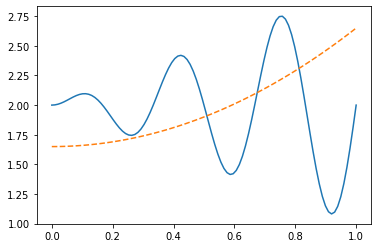

In [3]:
x = np.linspace(0,1,100)[:,None]
plt.figure()
plt.plot(x, vmap(f)(x))
plt.plot(x, vmap(g)(x), '--')

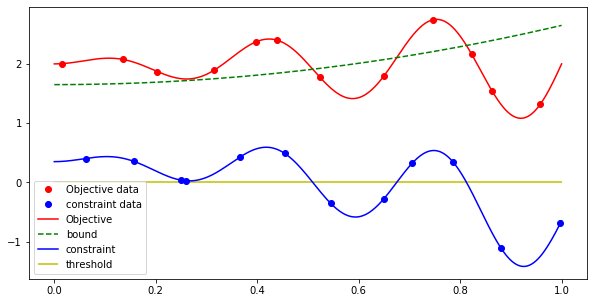

In [4]:
# Problem settings
dim = 1
N_f = 12
N_c = 12
noise_f = 0.0
noise_c = 0.0
options = {'kernel': 'RBF',
           'criterion': 'LCBC', 
           'input_prior': None,
           'kappa': 2.0,
           'nIter': None}
gp_model = MultipleIndependentOutputsGP(options)

# Domain bounds
lb = 0.0*np.ones(dim)
ub = 1.0*np.ones(dim)
bounds = {'lb': lb, 'ub': ub}

# Initial training data for objective
X_f = lb + (ub-lb)*lhs(dim, N_f)
y_f = vmap(f)(X_f)
y_f = y_f + noise_f*y_f.std(0)*onp.random.normal(y_f.shape)

# Initial training data for constraint
X_c = lb + (ub-lb)*lhs(dim, N_c)
y_c = vmap(constraint)(X_c)
y_c = y_c + noise_c*y_c.std(0)*onp.random.normal(y_c.shape)

# Test data
X_star = np.linspace(lb, ub, 500)
y_f_star = vmap(f)(X_star)
y_g_star = vmap(g)(X_star)
y_c_star = vmap(constraint)(X_star)

plt.figure(figsize = (10, 5))
plt.plot(X_f, y_f, 'ro', label = "Objective data")
plt.plot(X_c, y_c, 'bo', label = "constraint data")
plt.plot(X_star, y_f_star, 'r-', label = "Objective")
plt.plot(X_star, y_g_star, 'g--', label = "bound")
plt.plot(X_star, y_c_star, 'b-', label = "constraint")
plt.hlines(0, 0, 1, colors='y', label = "threshold")
plt.legend()


In [5]:
rng_key = random.PRNGKey(0)
# Fetch normalized training data
norm_batch_f, norm_const_f = normalize(X_f, y_f, bounds)
norm_batch_c, norm_const_c = normalize(X_c, y_c, bounds)
norm_batch_list = [norm_batch_f, norm_batch_c]
norm_const_list = [norm_const_f, norm_const_c]


# Train GP model
print('Train GP...')
rng_key = random.split(rng_key, 2)[0]
opt_params_list = gp_model.train(norm_batch_list,
                                 rng_key,
                                 num_restarts = 10)



Train GP...


In [6]:
mu_y = norm_const_list[0]['mu_y']
sigma_y = norm_const_list[0]['sigma_y']

print(sigma_y)

0.37318341970798075


(2, 500) (2, 500) (2, 500) (2, 500)


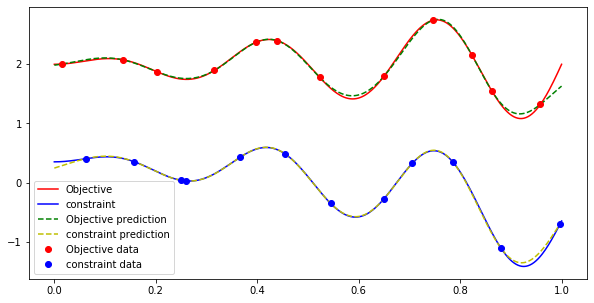

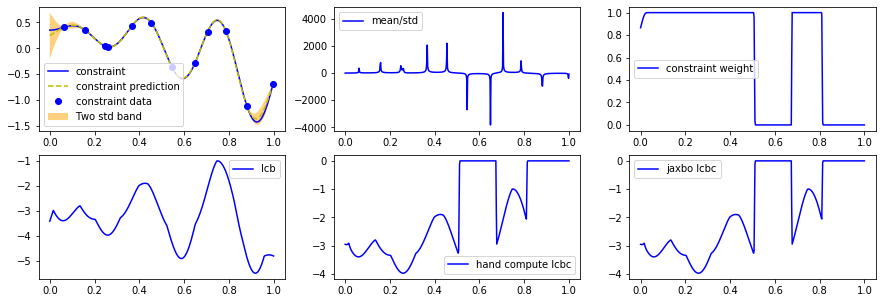

In [7]:
from jax.scipy.stats import norm

kwargs = {'params': opt_params_list,
          'batch': norm_batch_list,
          'norm_const': norm_const_list,
          'bounds': bounds,
          'kappa': gp_model.options['kappa']}
mean, std = gp_model.predict(X_star, **kwargs) # (1 + num_c, 500), (1 + num_c, 500)
lower = mean - 2.0*std
upper = mean + 2.0*std


acq_fn = lambda x: gp_model.acquisition(x, **kwargs) # LCBC, EIC = EI * CDF(z)
acq = vmap(acq_fn)(X_star)

kappa = 2.0
LCB = (mean[0,:] - mu_y) / sigma_y - 3. - kappa*std[0,:]/sigma_y # LCBC = LCB * CDF(z) \in [0,1] = mu - kappa * std <= 0 

print(mean.shape, std.shape, lower.shape, upper.shape)

plt.figure(figsize = (10, 5))
plt.plot(X_star, y_f_star, 'r-', label = "Objective")
plt.plot(X_star, y_c_star, 'b-', label = "constraint")
plt.plot(X_star, mean[0,:], 'g--', label = "Objective prediction")
plt.plot(X_star, mean[1,:], 'y--', label = "constraint prediction")
plt.plot(X_f, y_f, 'ro', label = "Objective data")
plt.plot(X_c, y_c, 'bo', label = "constraint data")
plt.legend()


plt.figure(figsize = (15, 5))
plt.subplot(2,3,1)
plt.plot(X_star, y_c_star, 'b-', label = "constraint")
plt.plot(X_star, mean[1,:], 'y--', label = "constraint prediction")
plt.plot(X_c, y_c, 'bo', label = "constraint data")
plt.fill_between(X_star.flatten(), lower[1,:], upper[1,:], 
                     facecolor='orange', alpha=0.5, label="Two std band")
plt.legend()

plt.subplot(2,3,2)
plt.plot(X_star, mean[1,:] / std[1,:], 'b-', label = "mean/std")
plt.legend()


plt.subplot(2,3,3)
plt.plot(X_star, norm.cdf(mean[1,:]/std[1,:]), 'b-', label = "constraint weight")
plt.legend()

plt.subplot(2,3,4)
plt.plot(X_star, LCB, 'b-', label = "lcb")
plt.legend()

plt.subplot(2,3,5)
plt.plot(X_star, LCB*norm.cdf(mean[1,:]/std[1,:]), 'b-', label = "hand compute lcbc")
plt.legend()

plt.subplot(2,3,6)
plt.plot(X_star, acq, 'b-', label = "jaxbo lcbc")
plt.legend()


# weight = CDF(mu / std)


In [8]:
from jax.scipy.stats import norm
out = np.prod(norm.cdf(mean[1:,:]/std[1:,:]), axis = 0)
# out = norm.cdf(mean[1:,:]/std[1:,:])
# out = np.prod(out, axis = 0)
print(out.shape)
acq_fn = lambda x: gp_model.acquisition(x, **kwargs)
acq = vmap(acq_fn)(X_star)
# print(acq)


(500,)


In [9]:
print('Computing next acquisition point...')
kwargs = {'params': opt_params_list,
          'batch': norm_batch_list,
          'norm_const': norm_const_list,
          'bounds': bounds,
          'kappa': options['kappa'],
          'gmm_vars': None}
new_X = gp_model.compute_next_point_lbfgs(num_restarts=10, **kwargs)
print(new_X)



Computing next acquisition point...
[[0.25878658]]


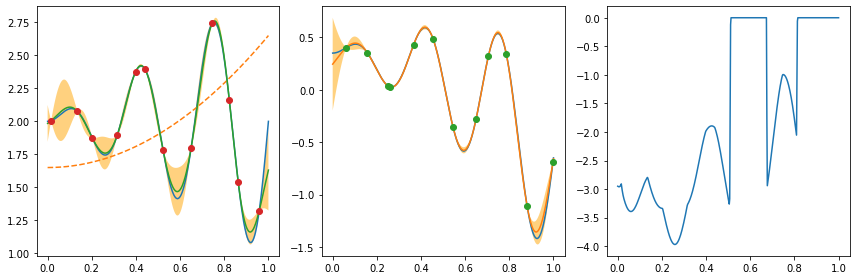

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(X_star, y_f_star)
plt.plot(X_star, y_g_star, '--')
plt.plot(X_star, mean[0,:])
plt.fill_between(X_star.flatten(), lower[0,:], upper[0,:], 
                     facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_f, y_f, 'o')
plt.subplot(1,3,2)
plt.plot(X_star, y_c_star)
plt.plot(X_star, mean[1,:])
plt.fill_between(X_star.flatten(), lower[1,:], upper[1,:], 
                     facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_c, y_c, 'o')

plt.subplot(1,3,3)
plt.plot(X_star, acq)
plt.tight_layout()

